### LSTM

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [118]:
# Read dataset to dataframe
df = pd.read_csv('../../data/processed/preprocessed_cupid.csv', usecols=['age', 'sex','#anwps', 'text', 'clean_text', 'isced', 'isced2'])
df = df.dropna(subset=['clean_text', 'isced'])
df.head()

,age,sex,text,isced,isced2,#anwps,clean_text
0,22,m,about me:i would love to think that i was some...,3.0,Upper secondary education,15.000000,mei love think kind intellectualeither dumbest...
2,38,m,"i'm not ashamed of much, but writing public te...",7.0,Master or equivalent,18.000000,im ashamed writing public text onlinedating si...
3,23,m,i work in a library and go to school. . . read...,3.0,Upper secondary education,10.750000,work library school reading things written old...
4,29,m,hey how's it going? currently vague on the pro...,6.0,Bachelor or equivalent,11.833333,hey hows going currently vague profile know to...
5,29,m,"i'm an australian living in san francisco, but...",6.0,Bachelor or equivalent,11.840000,im australian living san francisco dont hold t...


In [119]:
df1 = df
print("unique class values in the original dataset:", df1['isced'].unique())
print("classes count table: ", pd.crosstab(index=df1['isced'], columns='count'))

# Merge class 1.0, 3.0 and 5.0
df1['isced'].mask(df1['isced'].isin([3.0, 5.0]) , 1.0, inplace=True)
# Merge class 6.0, 7.0 and 8.0
df1['isced'].mask(df1['isced'].isin([6.0, 7.0]) , 8.0, inplace=True)

unique class values in the original dataset: [3. 7. 6. 8. 5. 1.]
classes count table:  col_0  count
isced       
1.0      177
3.0     9353
5.0     1450
6.0    25849
7.0    10314
8.0     2781


unique class values after merging: [1. 8.]
count table after merging: col_0  count
isced       
1.0    10980
8.0    38944


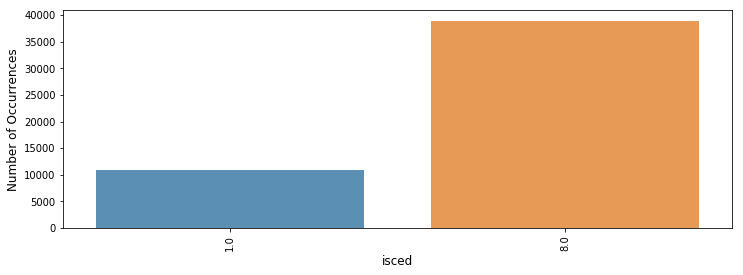

In [120]:
print('unique class values after merging:', df1['isced'].unique())
print("count table after merging:", pd.crosstab(index=df1['isced'], columns='count'))
# classes distribution
cnt_isced = df1['isced'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_isced.index, cnt_isced.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('isced', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [141]:
df1 = df1.dropna(subset=['clean_text', 'isced'])
X = df1.clean_text
Y = df1.isced


In [142]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [143]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [151]:
max_words = 2000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN

In [152]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [153]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 150, 50)           100000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [154]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 33948 samples, validate on 8487 samples
Epoch 1/10
33948/33948 [==============================] - 60s 2ms/step - loss: 0.4584 - acc: 0.8027 - val_loss: 0.4751 - val_acc: 0.8198
Epoch 2/10
33948/33948 [==============================] - 57s 2ms/step - loss: 0.3968 - acc: 0.8323 - val_loss: 0.3995 - val_acc: 0.8317
Epoch 3/10
33948/33948 [==============================] - 57s 2ms/step - loss: 0.3768 - acc: 0.8416 - val_loss: 0.3946 - val_acc: 0.8329
Epoch 4/10
33948/33948 [==============================] - 55s 2ms/step - loss: 0.3649 - acc: 0.8484 - val_loss: 0.4037 - val_acc: 0.8170


In [155]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [156]:
accr = model.evaluate(test_sequences_matrix,Y_test)

7489/7489 [==============================] - 4s 470us/step


In [157]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.400
  Accuracy: 0.826
